# DATA VISUALIZATION, EXPLORATION, AND MACHINE LEARNING APPLIED TO PROJECT-LEVEL DATA

In [3]:
# Initialize packages
library(DataCombine)
library(reshape2)
library(car)
library(MASS)
library(ggplot2)
library(plotly)
library(GGally)
library(tidyverse)
library(RcppRoll)
library(psych)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(purrr)
library(broom)
library(ranger)
library(xgboost)
library(elasticnet)
library(penalized)
library(bst)
library(leaps)
library(e1071)
library(superpc)
library(kernlab)
library(pls)
library(keras)
library(tensorflow)
library(mboost)
library(import)
library(gridExtra)

In [4]:
#Global options (plot size, default = 7)
options(repr.plot.width=7, repr.plot.height=7)
theme_set(theme_classic())

In [5]:
# Read in data file
filename <- 'hainan3.csv'
df <- read.csv(filename, na.strings=c("NA",""))

In [6]:
# Convert variables to numeric
df$Water_Aux <- as.numeric(df$Water_Aux)
df$ProjectElectricityUse_Aux <- as.numeric(df$ProjectElectricityUse_Aux)
df$FeCl_Aux <- as.numeric(df$FeCl_Aux)

In [7]:
# summary(df)

In [8]:
my_theme <- function(base_size = 10, base_family = "sans"){
  theme_minimal(base_size = base_size, base_family = base_family) +
    theme(
      axis.text = element_text(size = 10),
      axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 0.5),
      axis.title = element_text(size = 12),
      panel.grid.major = element_line(color = "grey"),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "#fcf9ff"),
      strip.background = element_rect(fill = "#3d0066", color = "#3d0066", size =0.5),
      strip.text = element_text(face = "bold", size = 10, color = "white"),
      legend.position = "bottom",
      legend.justification = "center",
      legend.background = element_blank(),
      panel.border = element_rect(color = "grey30", fill = NA, size = 0.5)
    )
}
theme_set(my_theme())

myfill=c("#f32440","#249ff2","#ba33e8","#ffbd0a")

mycolor=c("#b20018","#012670","#2b0354","#c42f01")

# Feature Engineering
### In this section, we create new features derived from the original dataset. We start with new features derived from project inputs and outputs

In [9]:
# First we define a function that makes a histogram and prints the range for our derived
# variables, so that we can check that there aren't any problems

In [10]:
#Makes histograms
check <- function(data = df, var, bin = 5){
    r <- range(var)
    p <- ggplot(data, aes(x = var)) +
    geom_histogram(binwidth = bin)
    print(p)
    print(r)
}

In [11]:
#Makes scatterplots
check2 <- function(data = df, x, y){
    p <- ggplot(data, aes(x,y)) +
    geom_point()
    print(p)
}

In [12]:
# Add a co-digested amount variable. This tells us how many co-digested substrates there were on 
# a given day
df$codigestedAmount <- as.integer(rowSums(df[ , grepl( "Input" , names( df ) ) ] > 0))

In [13]:
# Add a total waste input variable
df <- mutate(df, total_Input = select(df, contains("Input")) %>% rowSums(.))

In [14]:
# str(df)

In [15]:
#Add cumulative variables (inputs) running sums
df <- mutate(df,
             cum_total_Input = cumsum(df$total_Input),
             cum_PigManure_Input = cumsum(df$PigManure_Input),
             cum_Cassava_Input = cumsum(df$Cassava_Input),
             cum_FishWaste_Input = cumsum(df$FishWaste_Input),
             cum_FoodWaste_Input = cumsum(df$FoodWaste_Input),
             cum_MunFecalRes_Input = cumsum(df$MunFecalRes_Input),
             cum_TeaWaste_Input = cumsum(df$TeaWaste_Input),
             cum_ChickLitter_Input = cumsum(df$ChickLitter_Input),
             cum_Baggasse_Input = cumsum(df$Baggasse_Input),
             cum_AlcoWaste_Input = cumsum(df$AlcoWaste_Input),
             cum_MedicineWaste_Input = cumsum(df$MedicineWaste_Input),
             cum_EnergyGrass_Input = cumsum(df$EnergyGrass_Input),
             cum_BananaShafts_Input = cumsum(df$BananaShafts_Input),
             cum_LemonWaste_Input = cumsum(df$LemonWaste_Input),
             cum_Percolate_Input = cumsum(df$Percolate_Input),
             cum_Other_Input = cumsum(df$Other_Input))             

In [16]:
#Add cumulative variables (outputs) running sums
df <- mutate(df,
            cum_BioCNG_Output = cumsum(df$BioCNG_Output),
            cum_LiqFert_Output = cumsum(df$LiqFert_Output),
            cum_SolFert_Output = cumsum(df$SolFert_Output))

### The above code created cumulative sums. However,our machine learning models will predict future biogas output. This means we need to introduce a time lag variable, i.e. BioCNG output 30 days from now (this assumes the HRT is equal to 10, 20, or 30). The project operator can decide how far ahead to predict!

In [17]:
#One-day output in the future
df$BioCNG30daysAhead <- lag(df$BioCNG_Output, +30)
df$BioCNG20daysAhead <- lag(df$BioCNG_Output, +20)
df$BioCNG10daysAhead <- lag(df$BioCNG_Output, +10)

In [18]:
#Cumulative output in the future
df$cumFuture_BioCNG30daysAhead <- lag(df$cum_BioCNG_Output, +30)
df$cumFuture_BioCNG20daysAhead <- lag(df$cum_BioCNG_Output, +20)
df$cumFuture_BioCNG10daysAhead <- lag(df$cum_BioCNG_Output, +10)

In [19]:
# summary(df)
# str(df)

# Machine learning
### In this section, we apply ML algorithms including, glmnet, decision trees, random forest, and xgboost to predict future output.

In [20]:
# First, we subset our original dataframe to get the required variables. We start with building

In [21]:
df2 <- select(df,Day.Nber,
             cum_BioCNG_Output:cumFuture_BioCNG10daysAhead, 
             BioCNG_Output,
             PigManure_Input:Other_Input,
             codigestedAmount:cum_Other_Input
             )

In [22]:
# names(df2)

In [23]:
df2 <- subset(df2, BioCNG30daysAhead != "NA")
# sum(is.na(df2) == TRUE)
# sum(is.na(df2))

In [24]:
#Determine the train-test split ratio
trainRatio = 0.90
split <- round(nrow(df2)*trainRatio)
train <- df2[1:split,]
test <- df2[(split + 1):nrow(df2), ]

In [25]:
#Define OSR2 function
# convenience function, you're welcome :) 
OSR2 <- function(predictions, test, train) {
  SSE <- sum((test - predictions)^2)
  SST <- sum((test - mean(train))^2)
  r2 <- 1 - SSE/SST
  return(r2)
}

In [26]:
#Set seed for reproducible results
set.seed(1)

### Simple models and some visualization
#### What kind of accuracy do we get with a simple, baseline model based on input amount only?

#### Baseline models

In [27]:
#Train model
lm_simple <- lm(formula = BioCNG30daysAhead ~ total_Input, data = df)

In [28]:
summary(lm_simple)


Call:
lm(formula = BioCNG30daysAhead ~ total_Input, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12067.7  -1363.6   -348.3   1222.6  11177.8 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2911.1052    86.3197   33.73   <2e-16 ***
total_Input   13.6334     0.3136   43.47   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2455 on 1366 degrees of freedom
  (30 observations deleted due to missingness)
Multiple R-squared:  0.5804,	Adjusted R-squared:  0.5801 
F-statistic:  1890 on 1 and 1366 DF,  p-value: < 2.2e-16


In [29]:
# Create a new vector in the dataframe with model's predicted values 
test$lm_simple_preds <- predict(lm_simple, test)

In [30]:
# Calculate out-of-sample R2
lm_simple_OSR2 <- OSR2(test$lm_simple_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
lm_simple_OSR2

[1] 0.7198228

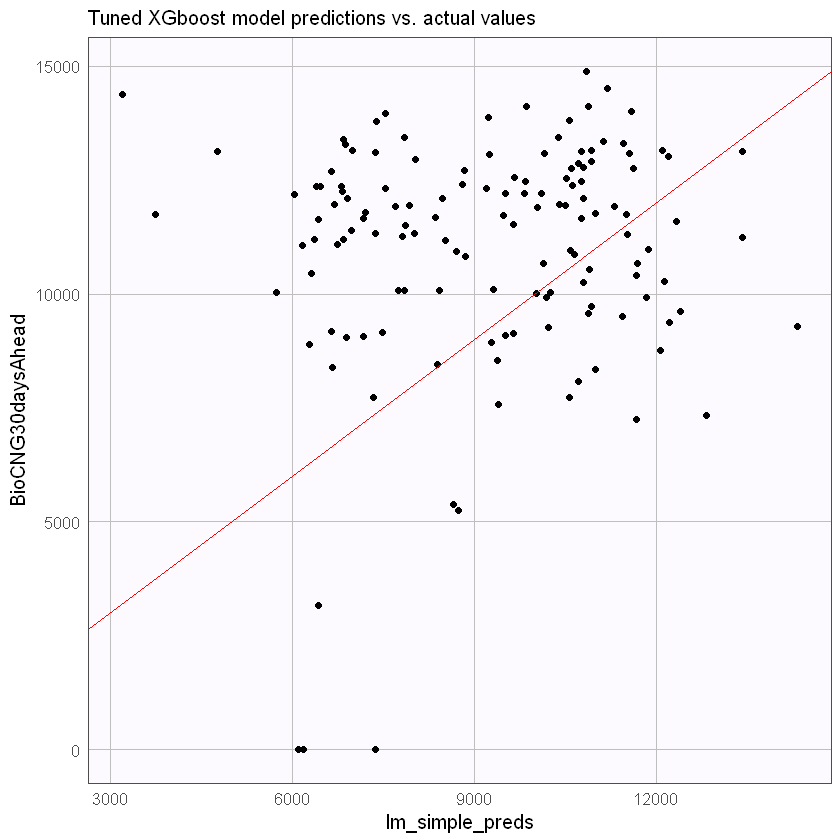

In [31]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=lm_simple_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned XGboost model predictions vs. actual values")

In [32]:
# New vector of residuals
test$lm_simple_residuals <- test$BioCNG30daysAhead - test$lm_simple_preds

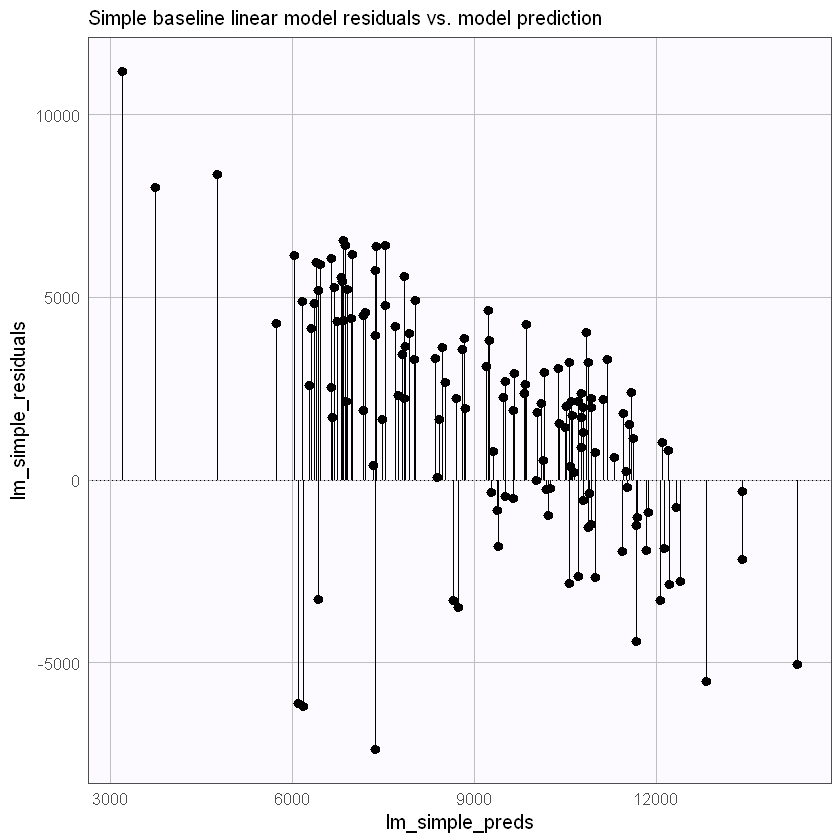

In [33]:
ggplot(test, aes(x = lm_simple_preds, y = lm_simple_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = lm_simple_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Simple baseline linear model residuals vs. model prediction")

### Some visualization of model fits for a one-feature model

In [34]:
p1 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.5, color = "grey") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 1),color="black",fill="grey80") +
    ggtitle("Linear")

In [35]:
p2 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.05,color="#249ff2") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 2),color="#b20018",fill="#f32440") +
    ggtitle("Quadratic")

In [36]:
p3 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.5, color="#f32440") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 3),color="#012670",fill="#249ff2") +
    ggtitle("Cubic")

In [37]:
p4 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.05,color="#ba33e8") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 4),color="#2b0354",fill="#ba33e8") +
    ggtitle("Quartic")

In [38]:
p5 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.05,color="gold") +
    geom_smooth(method = "gam",color="orangered",fill="orange") +
    ggtitle("GAM")

In [39]:
p6 <- ggplot(train,aes(x=total_Input,y=BioCNG30daysAhead))+
    geom_point(alpha=0.05,color="#bde509") +
    geom_smooth(method = "lm", formula = y ~ splines::bs(x, 3),color="darkgreen",fill="#bde509") +
    ggtitle("LM+Cubic Spline")

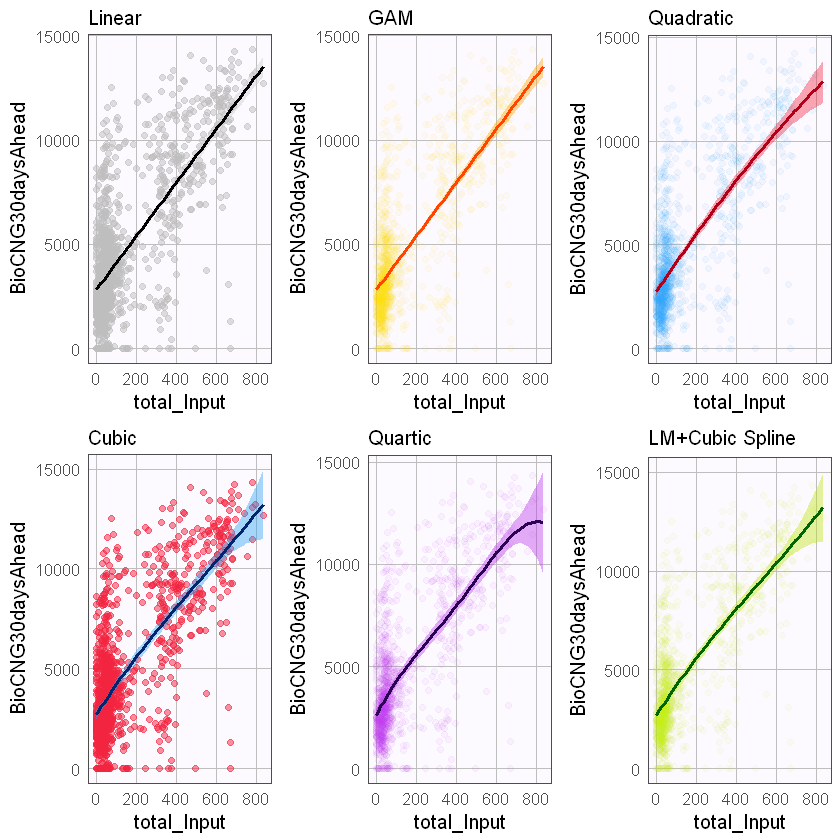

In [40]:
grid.arrange(p1,p5,p2,p3,p4,p6,ncol=3)

### Random Forest (Untuned)

In [41]:
# Train model
mod_rf_untuned <- randomForest(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           ntree = 1000, mtry = 6,
           data = train)

In [42]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_untuned_preds <- predict(mod_rf_untuned, test, type="response")

In [43]:
# Calculate out-of-sample R2
mod_rf_untuned_OSR2 <- OSR2(test$rf_untuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_rf_untuned_OSR2

[1] 0.8603799

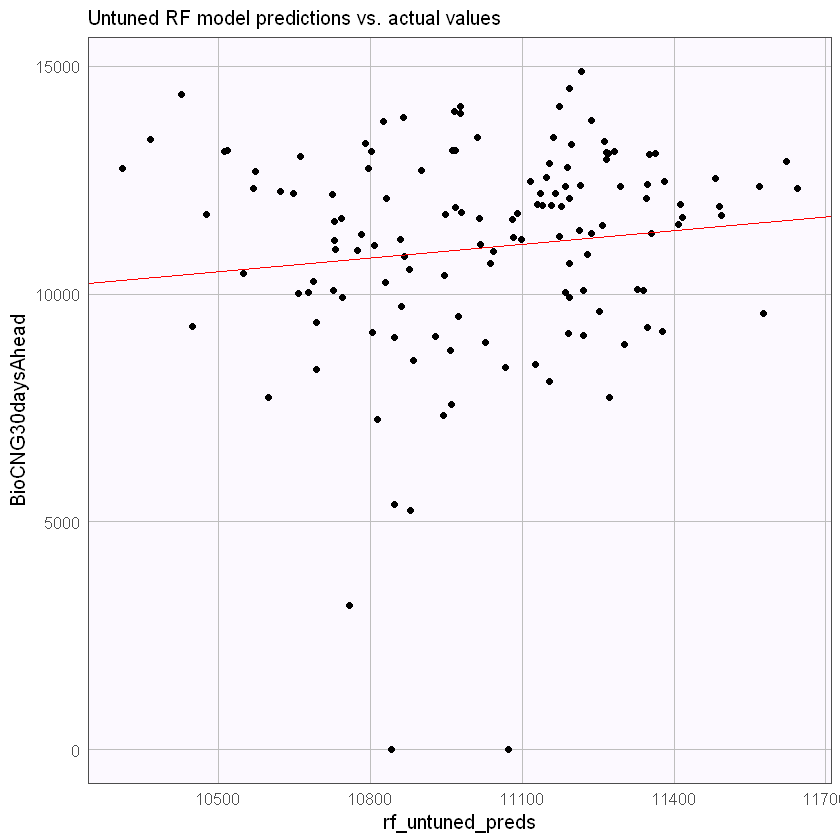

In [44]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=rf_untuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Untuned RF model predictions vs. actual values")

In [45]:
# New vector of residuals
test$rf_untuned_residuals <- test$BioCNG30daysAhead - test$rf_untuned_preds

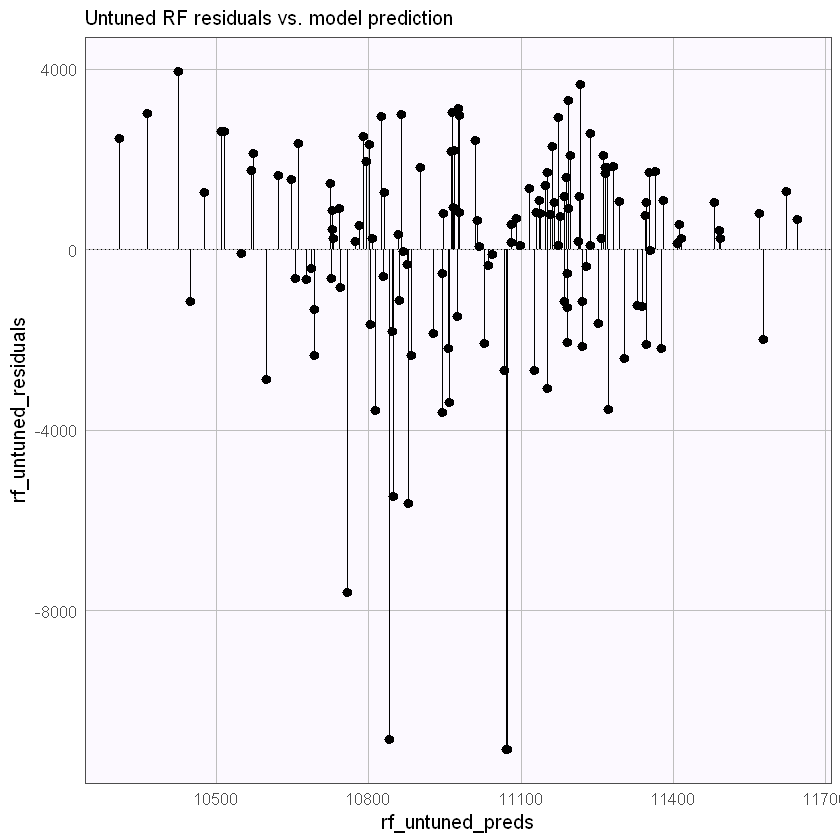

In [46]:
# Plot of residuals
ggplot(test, aes(x = rf_untuned_preds, y = rf_untuned_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = rf_untuned_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Untuned RF residuals vs. model prediction")

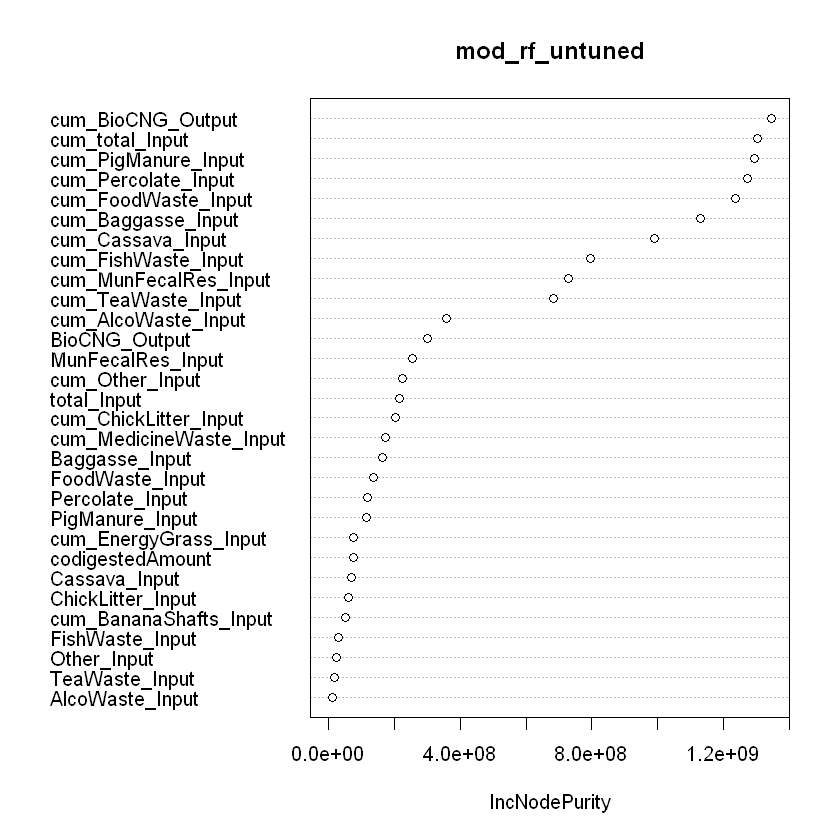

In [47]:
varImpPlot(mod_rf_untuned, type =2)

### Random Forest (Tuned)

In [48]:
# Define a grid of mtry values as tuning parameters. We will keep ntrees equal to 1,000
grid_rf <- expand.grid(.mtry = c(2,4,8,16))

In [705]:
# Train model
mod_rf_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "rf", metric = "RMSE", tuneGrid = grid_rf, ntree=1000,
           data = train)

In [221]:
# # Train model
# mod_rf_tuned <- train(BioCNG30daysAhead ~ 
#            cum_BioCNG_Output +
#            BioCNG_Output +
#            PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
#            MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
#            AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
#            LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
#            cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
#            cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
#            cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
#            cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
#            cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
#            method = "ranger",
#            data = train)

In [49]:
# save(mod_rf_tuned, file="rf.rda")
load("rf.rda")

In [50]:
mod_rf_tuned

Random Forest 

1231 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1231, 1231, 1231, 1231, 1231, 1231, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1573.676  0.7859901  1073.0865
   2    extratrees  1719.954  0.7451597  1195.2183
  18    variance    1391.428  0.8293873   893.0958
  18    extratrees  1328.738  0.8443738   846.1533
  35    variance    1499.763  0.8019686   974.6541
  35    extratrees  1344.115  0.8407554   854.8125

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 18, splitrule = extratrees
 and min.node.size = 5.

In [51]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned_preds <- predict(mod_rf_tuned, test)

In [52]:
# Calculate out-of-sample R2
mod_rf_tuned_OSR2 <- OSR2(test$rf_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_rf_tuned_OSR2

[1] 0.8649955

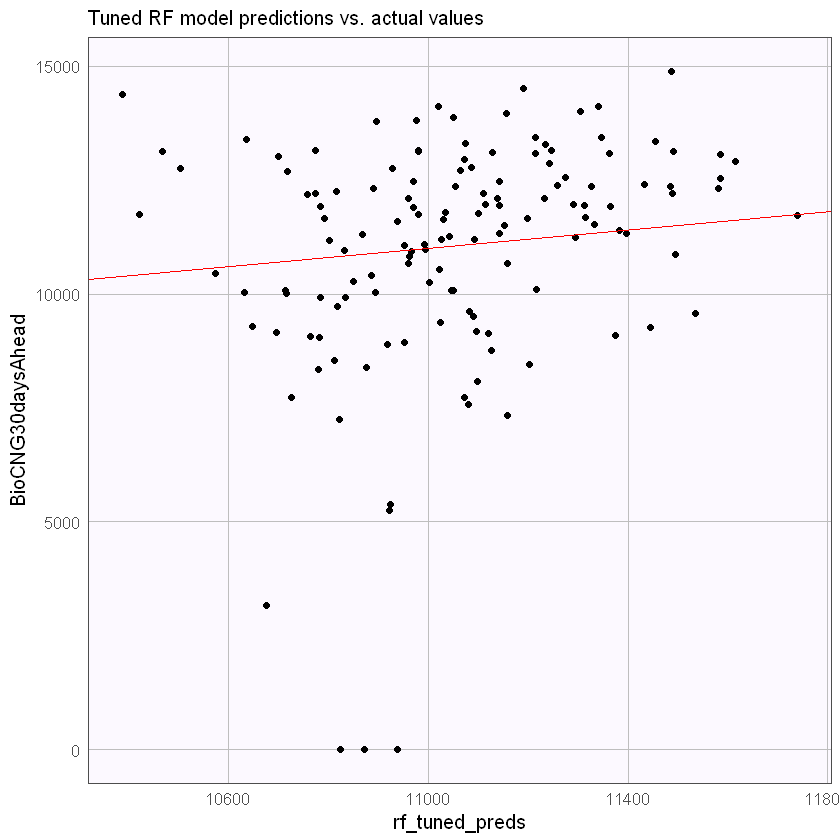

In [53]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=rf_tuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned RF model predictions vs. actual values")

In [54]:
# New vector of residuals
test$rf_tuned_residuals <- test$BioCNG30daysAhead - test$rf_tuned_preds

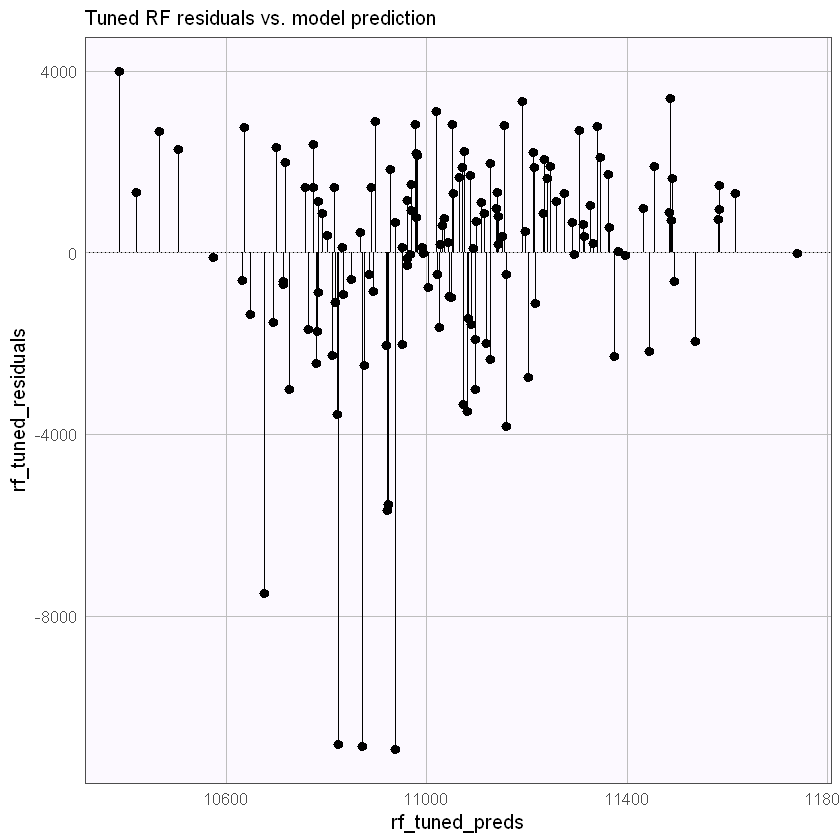

In [55]:
ggplot(test, aes(x = rf_tuned_preds, y = rf_tuned_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = rf_tuned_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Tuned RF residuals vs. model prediction")

In [56]:
mod_rf_tuned$results

mtry,min.node.size,splitrule,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
2,5,variance,1573.676,0.7859901,1073.0865,84.38785,0.02798416,44.39739
2,5,extratrees,1719.954,0.7451597,1195.2183,80.63495,0.02992756,44.20586
18,5,variance,1391.428,0.8293873,893.0958,102.94646,0.02626269,51.44483
18,5,extratrees,1328.738,0.8443738,846.1533,94.54210,0.02337433,42.97397
35,5,variance,1499.763,0.8019686,974.6541,110.00637,0.03004142,61.34021
35,5,extratrees,1344.115,0.8407554,854.8125,98.00831,0.02438603,44.34608


### Partial least squares

In [57]:
# Train model
pls_model_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input+ codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
  data=train,
  method = "pls", tuneLength = 4
)

In [58]:
pls_model_tuned

Partial Least Squares 

1231 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1231, 1231, 1231, 1231, 1231, 1231, ... 
Resampling results across tuning parameters:

  ncomp  RMSE      Rsquared   MAE     
  1      2454.667  0.4698007  1971.673
  2      2252.952  0.5534704  1678.130
  3      2160.753  0.5889139  1547.458
  4      2080.993  0.6186945  1479.363

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was ncomp = 4.

In [59]:
# Create a new vector in the dataframe with model's predicted values 
test$pls_preds <- predict(pls_model_tuned, test)

In [60]:
# Calculate out-of-sample R2
mod_pls_tuned_OSR2 <- OSR2(test$pls_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_pls_tuned_OSR2

[1] 0.8170892

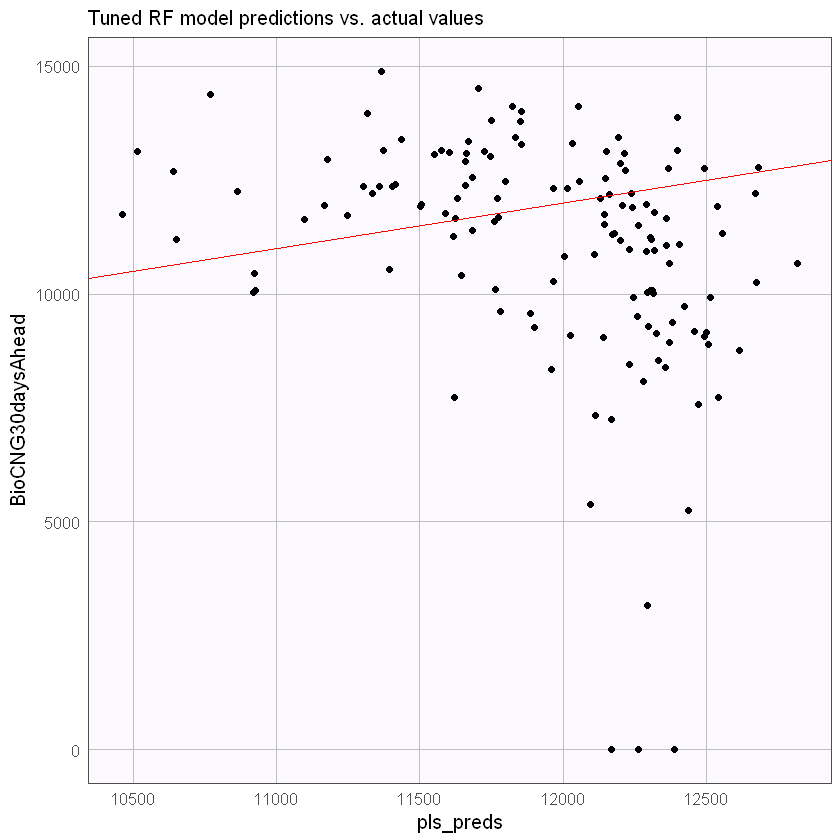

In [61]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=pls_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned RF model predictions vs. actual values")

In [62]:
# New vector of residuals
test$pls_tuned_residuals <- test$BioCNG30daysAhead - test$pls_preds

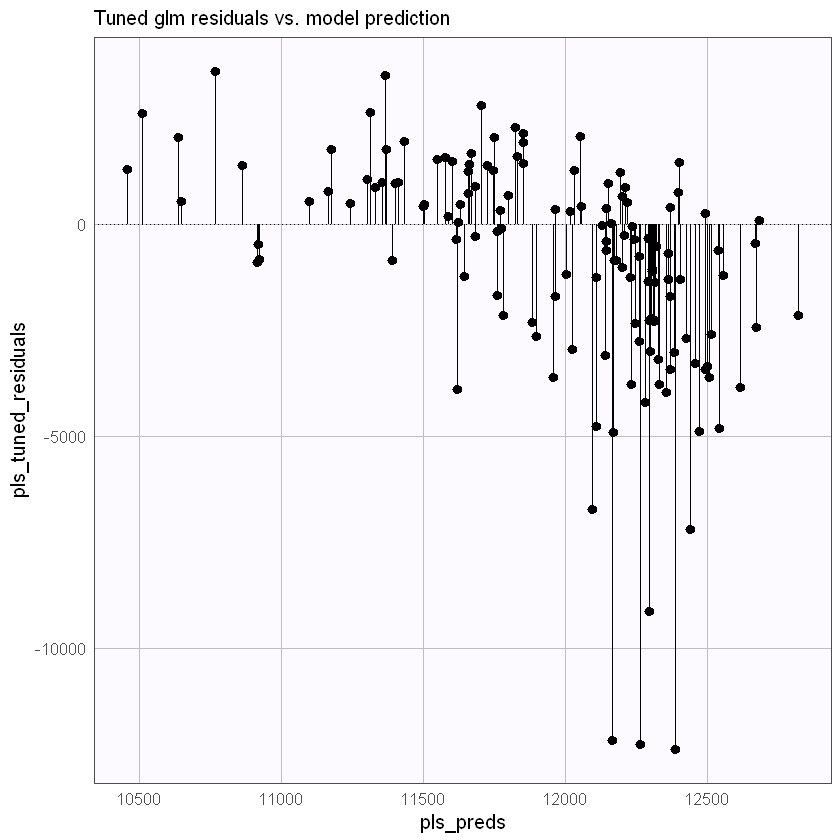

In [63]:
ggplot(test, aes(x = pls_preds, y = pls_tuned_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = pls_tuned_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Tuned glm residuals vs. model prediction")

In [64]:
pls_model_tuned$results

ncomp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,2454.667,0.4698007,1971.673,63.07860,0.02772078,52.56419
2,2252.952,0.5534704,1678.130,82.22845,0.03127840,42.93478
3,2160.753,0.5889139,1547.458,87.86840,0.03241763,45.24860
4,2080.993,0.6186945,1479.363,90.75660,0.02952079,61.14518


### Decision Tree

In [65]:
#Train model
rpart_mod_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "rpart", metric = "RMSE", tuneLength = 9,
           data = train)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

In [242]:
# rpart_mod_tuned

In [66]:
# Create a new vector in the dataframe with model's predicted values 
test$rpart_tuned_preds <- predict(rpart_mod_tuned, test)

In [67]:
# Calculate out-of-sample R2
mod_rpart_tuned_OSR2 <- OSR2(test$rpart_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_rpart_tuned_OSR2

[1] 0.8582117

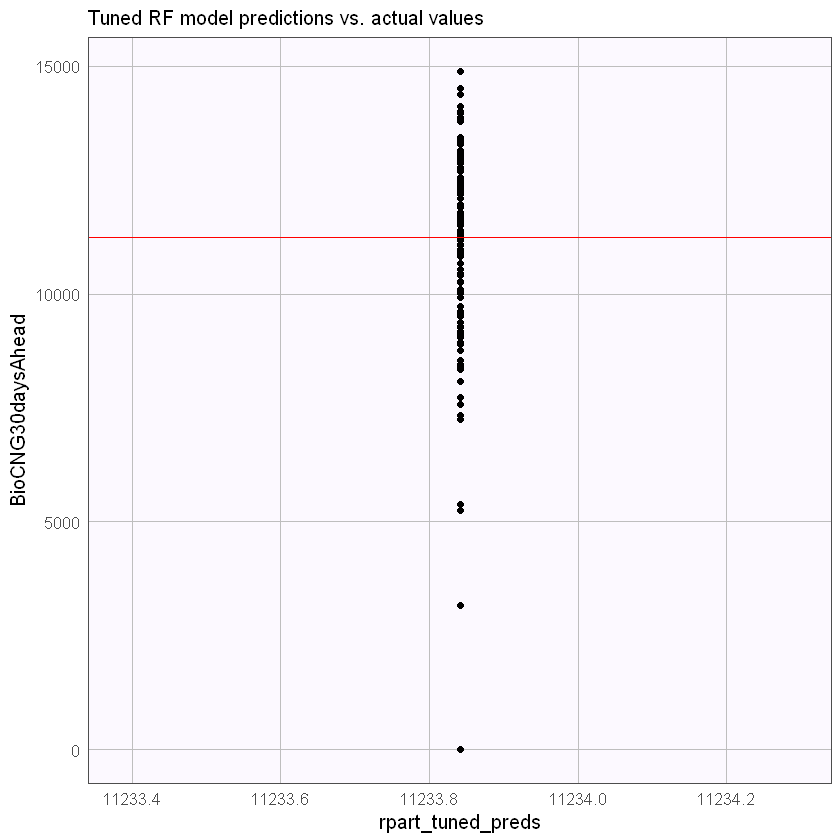

In [68]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=rpart_tuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned RF model predictions vs. actual values")

In [69]:
# New vector of residuals
test$rpart_tuned_residuals <- test$BioCNG30daysAhead - test$rpart_tuned_preds

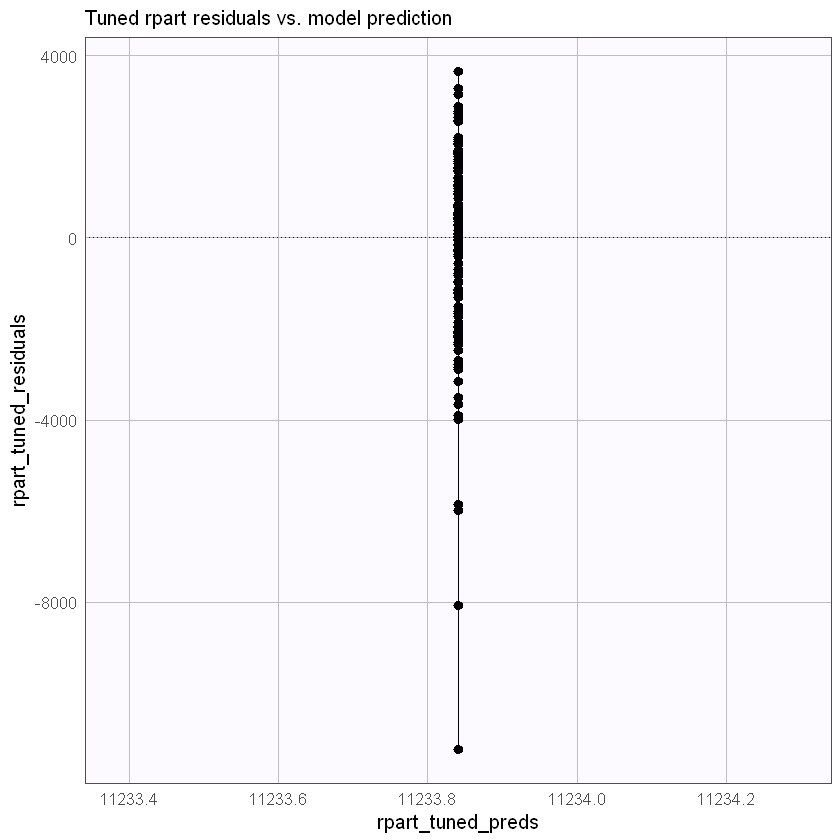

In [70]:
ggplot(test, aes(x = rpart_tuned_preds, y = rpart_tuned_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = rpart_tuned_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Tuned rpart residuals vs. model prediction")

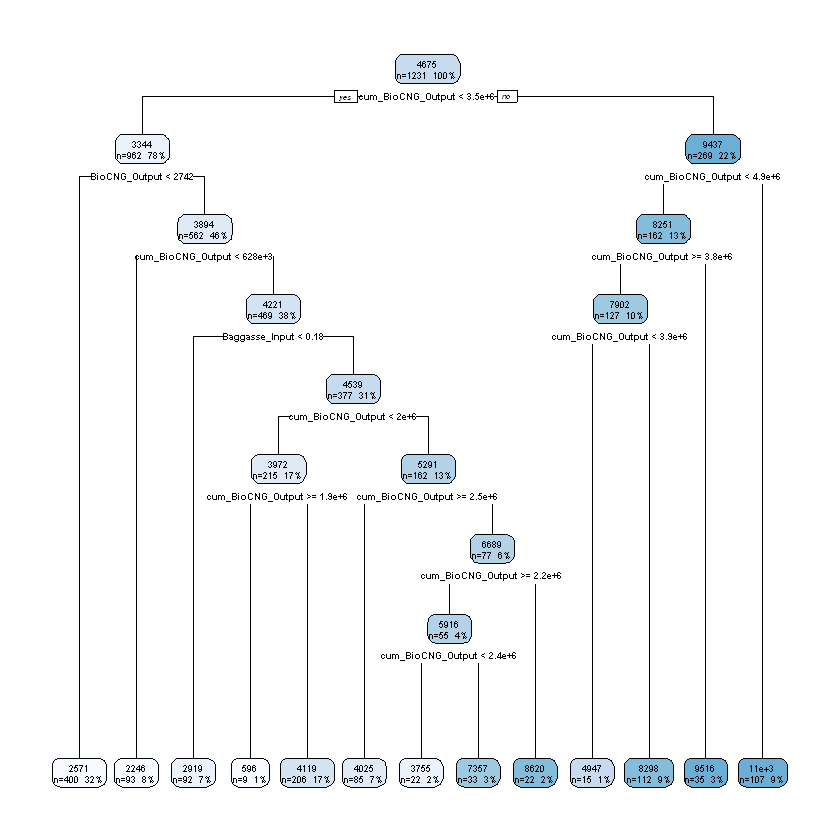

In [71]:
rpart.plot(rpart_mod_tuned$finalModel, digits =2, extra=101)

In [72]:
rpart_mod_tuned$results

cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
0.005000915,1751.118,0.7279730,1207.924,120.70092,0.03699138,83.71382
0.007770795,1798.995,0.7120242,1256.867,112.66219,0.03485209,85.14617
0.007989084,1799.239,0.7118788,1257.614,108.20384,0.03383720,81.64608
0.010392191,1861.411,0.6920940,1312.206,93.89464,0.03049500,67.08244
0.015528258,1899.612,0.6786693,1344.975,89.08413,0.03163009,62.50017
0.021986747,1957.836,0.6590119,1387.815,82.14391,0.02503773,64.31197
0.029714626,2073.490,0.6168190,1495.082,76.40486,0.03090023,59.15156
0.041638710,2150.731,0.5882755,1578.879,91.38100,0.03042044,82.64712
0.566850781,2819.948,0.5494115,2212.956,562.99505,0.01757194,540.18032


### XGboost

In [258]:
#Train model
xgb_tune <-train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=T,
                     metric="RMSE",
                     tuneLength = 2)

In [73]:
# save(xgb_tune, file="xgb.rda")
load("xgb.rda")

In [74]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned_preds <- predict(xgb_tune, test)

In [75]:
# Calculate out-of-sample R2
xgb_tuned_OSR2 <- OSR2(test$xgb_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
xgb_tuned_OSR2

[1] 0.8631993

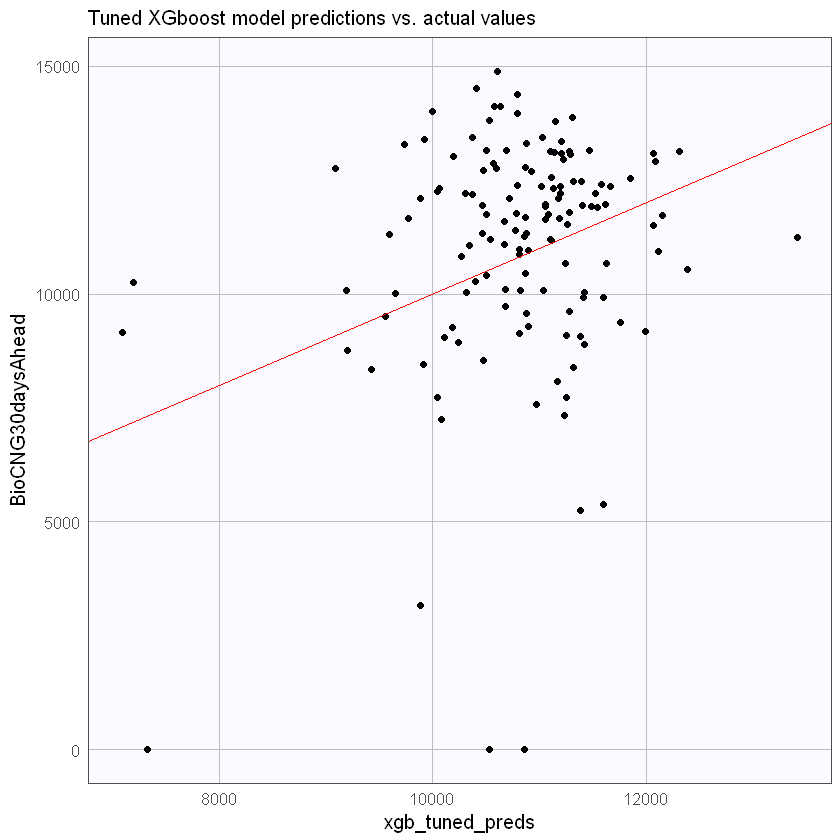

In [76]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=xgb_tuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned XGboost model predictions vs. actual values")

In [77]:
# New vector of residuals
test$xgboost_tuned_residuals <- test$BioCNG30daysAhead - test$xgb_tuned_preds

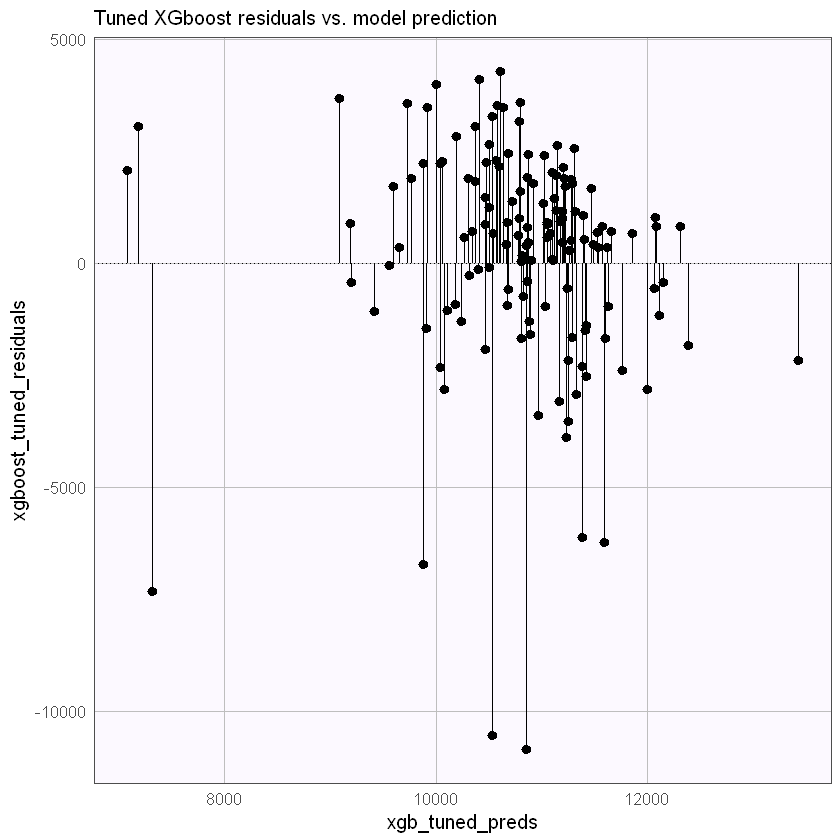

In [78]:
ggplot(test, aes(x = xgb_tuned_preds, y = xgboost_tuned_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = xgboost_tuned_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Tuned XGboost residuals vs. model prediction")

In [79]:
xgbResults <- xgb_tune$results
xgbResults

,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.3,1,0,0.6,1,0.5,50,1870.567,0.6876505,1324.568,84.23859,0.03155665,55.33022
3,0.3,1,0,0.6,1,1.0,50,1847.526,0.6972429,1313.759,78.34256,0.02984694,53.92306
5,0.3,1,0,0.8,1,0.5,50,1874.433,0.6863859,1325.937,85.82281,0.03216967,56.32174
7,0.3,1,0,0.8,1,1.0,50,1846.379,0.6976895,1311.150,73.58447,0.02923624,47.54756
17,0.4,1,0,0.6,1,0.5,50,1859.126,0.6915362,1313.628,77.32174,0.03110081,56.86577
19,0.4,1,0,0.6,1,1.0,50,1810.540,0.7082740,1279.196,80.14198,0.02911145,54.84642
21,0.4,1,0,0.8,1,0.5,50,1857.589,0.6914897,1313.124,87.14320,0.03307134,61.59462
23,0.4,1,0,0.8,1,1.0,50,1815.127,0.7069270,1282.303,80.73545,0.02839154,53.45236
9,0.3,2,0,0.6,1,0.5,50,1632.970,0.7616839,1120.719,83.16539,0.02559412,50.01260
11,0.3,2,0,0.6,1,1.0,50,1574.882,0.7787149,1066.885,82.65253,0.02324990,58.23674


### Simple Linear Model

In [80]:
#Train model
lmfit <- lm(formula = BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input, 
           data = train)

In [81]:
summary(lmfit)


Call:
lm(formula = BioCNG30daysAhead ~ cum_BioCNG_Output + BioCNG_Output + 
    PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input + 
    MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + 
    Baggasse_Input + AlcoWaste_Input + MedicineWaste_Input + 
    EnergyGrass_Input + BananaShafts_Input + LemonWaste_Input + 
    Percolate_Input + Other_Input + codigestedAmount + total_Input + 
    cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + 
    cum_FishWaste_Input + cum_FoodWaste_Input + cum_MunFecalRes_Input + 
    cum_TeaWaste_Input + cum_ChickLitter_Input + cum_Baggasse_Input + 
    cum_AlcoWaste_Input + cum_MedicineWaste_Input + cum_EnergyGrass_Input + 
    cum_BananaShafts_Input + cum_LemonWaste_Input + cum_Percolate_Input + 
    cum_Other_Input, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11039.1   -804.5    -36.0    911.8   7403.4 

Coefficients: (2 not defined because of singularities)
                          Estimat

In [82]:
# Create a new vector in the dataframe with model's predicted values 
test$lm_preds <- predict(lmfit, test)

Warning message in predict.lm(lmfit, test):
"prediction from a rank-deficient fit may be misleading"

In [83]:
# Calculate out-of-sample R2
lm_OSR2 <- OSR2(test$lm_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
lm_OSR2

[1] -2.183422

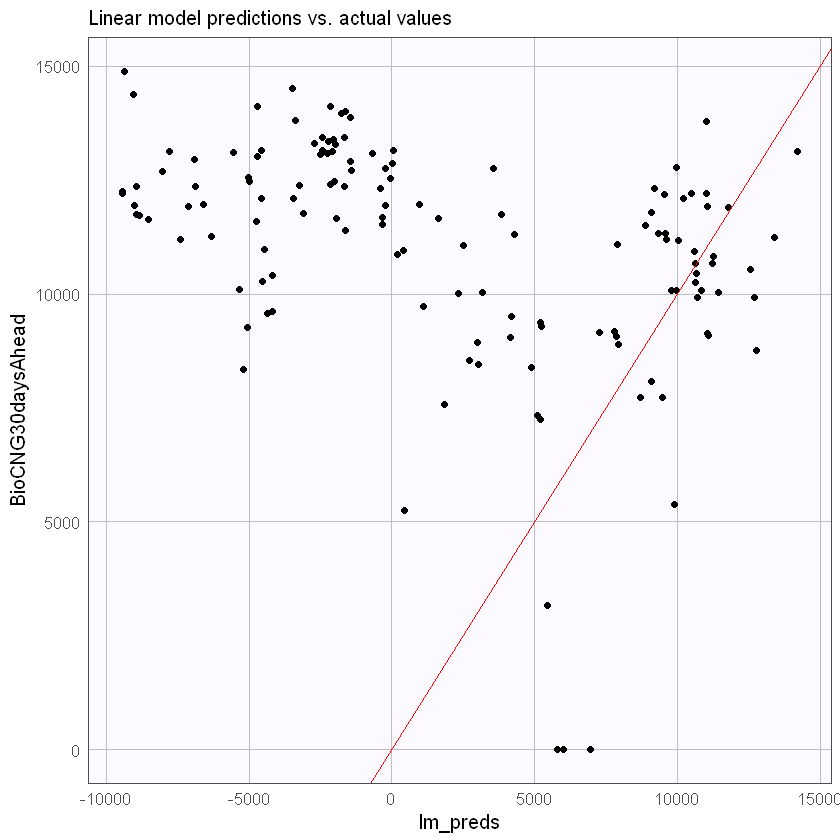

In [85]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=lm_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Linear model predictions vs. actual values")

In [86]:
# New vector of residuals
test$lm_residuals <- test$BioCNG30daysAhead - test$lm_preds

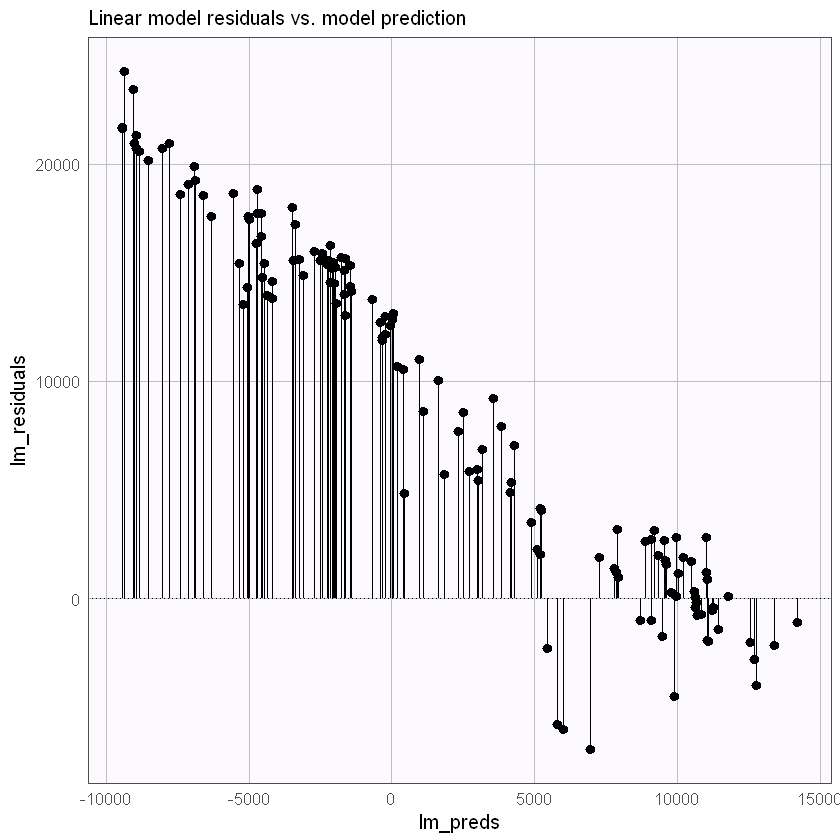

In [87]:
ggplot(test, aes(x = lm_preds, y = lm_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = lm_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Linear model residuals vs. model prediction")

In [88]:
summary(lmfit)


Call:
lm(formula = BioCNG30daysAhead ~ cum_BioCNG_Output + BioCNG_Output + 
    PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input + 
    MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + 
    Baggasse_Input + AlcoWaste_Input + MedicineWaste_Input + 
    EnergyGrass_Input + BananaShafts_Input + LemonWaste_Input + 
    Percolate_Input + Other_Input + codigestedAmount + total_Input + 
    cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + 
    cum_FishWaste_Input + cum_FoodWaste_Input + cum_MunFecalRes_Input + 
    cum_TeaWaste_Input + cum_ChickLitter_Input + cum_Baggasse_Input + 
    cum_AlcoWaste_Input + cum_MedicineWaste_Input + cum_EnergyGrass_Input + 
    cum_BananaShafts_Input + cum_LemonWaste_Input + cum_Percolate_Input + 
    cum_Other_Input, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11039.1   -804.5    -36.0    911.8   7403.4 

Coefficients: (2 not defined because of singularities)
                          Estimat

### Principal components regression

In [89]:
#Train model
pcr_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
  data=train,
  method = "superpc", tuneLength = 5
)

In [90]:
# Create a new vector in the dataframe with model's predicted values 
test$pcr_tuned_preds <- predict(pcr_tuned, test)

In [91]:
# Calculate out-of-sample R2
pcr_OSR2 <- OSR2(test$pcr_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
pcr_OSR2

[1] 0.7641474

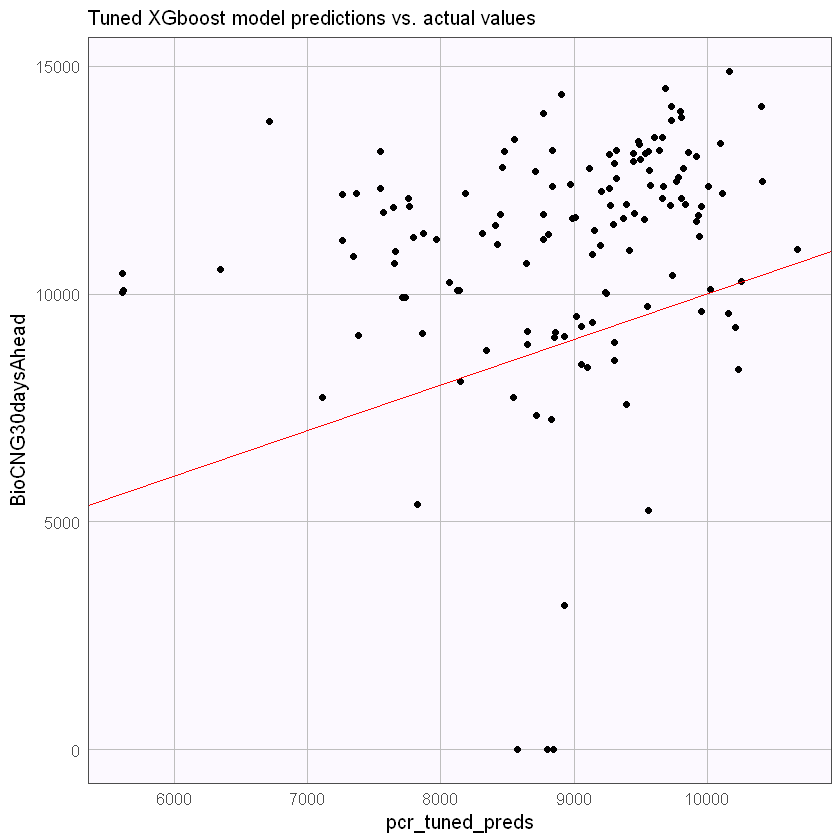

In [92]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=pcr_tuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned XGboost model predictions vs. actual values")

In [93]:
# New vector of residuals
test$pcr_residuals <- test$BioCNG30daysAhead - test$pcr_tuned_preds

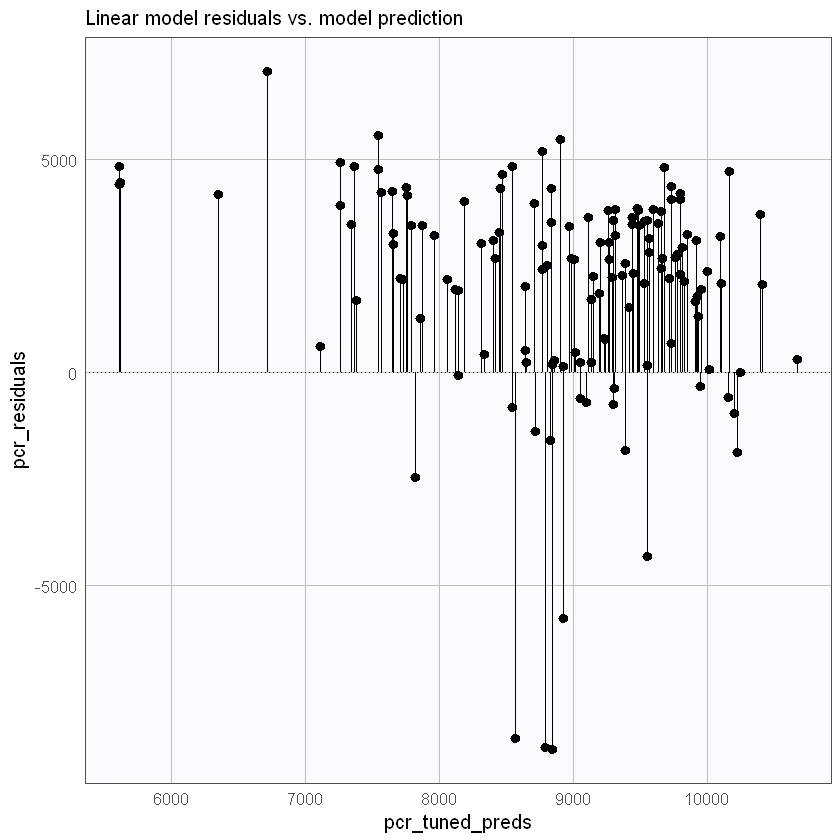

In [94]:
ggplot(test, aes(x = pcr_tuned_preds, y = pcr_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = pcr_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Linear model residuals vs. model prediction")

In [95]:
pcr_tuned$results

,n.components,threshold,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,1,0.1,5146.624,0.5553348,4689.082,93.02782,0.03588026,80.15930
6,2,0.1,5129.976,0.5723861,4692.689,90.33690,0.03430236,81.82679
11,3,0.1,5115.896,0.5898962,4709.326,92.81155,0.03331253,84.09366
2,1,0.3,5209.148,0.5104742,4704.298,90.01947,0.03120811,90.18455
7,2,0.3,5123.377,0.5803840,4699.381,91.92396,0.03488718,83.88579
12,3,0.3,5123.299,0.5834438,4711.506,92.96045,0.03354596,84.12931
3,1,0.5,5179.205,0.5257428,4691.626,95.59899,0.04742185,88.05514
8,2,0.5,5123.501,0.5791363,4698.077,91.33360,0.03463798,83.99984
13,3,0.5,5123.553,0.5820079,4709.920,92.66378,0.03331477,84.70277
4,1,0.7,5162.387,0.5435836,4723.227,91.15977,0.02788856,79.06223


### Linear regression with stepwise selection

In [96]:
#Train model
stepWiseLinReg_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
  data=train,
  method = "leapSeq"
)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
"2  linear dependencies found"

Reordering variables and trying again:


In [97]:
# Create a new vector in the dataframe with model's predicted values 
test$stepwiselm_tuned_preds <- predict(stepWiseLinReg_tuned, test)

In [98]:
# Calculate out-of-sample R2
stepwise_OSR2 <- OSR2(test$stepwiselm_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
stepwise_OSR2

[1] 0.8736403

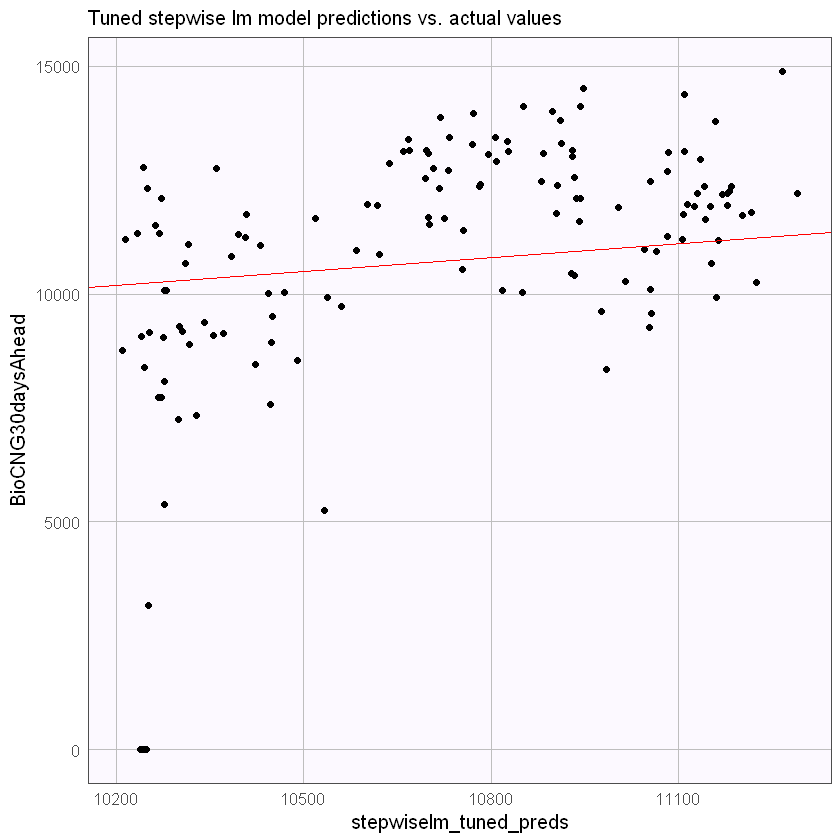

In [99]:
# Scatterplot of predicted vs. actual values
ggplot(test, aes(x=stepwiselm_tuned_preds, y=BioCNG30daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("Tuned stepwise lm model predictions vs. actual values")

In [100]:
# New vector of residuals
test$stepwiselm_residuals <- test$BioCNG30daysAhead - test$stepwiselm_tuned_preds

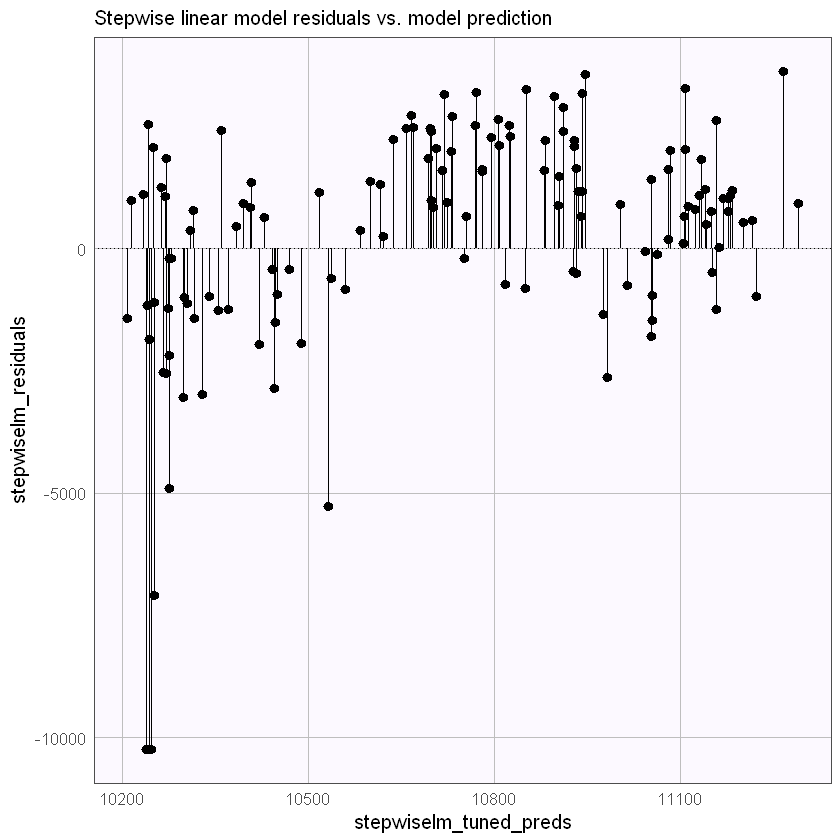

In [101]:
ggplot(test, aes(x = stepwiselm_tuned_preds, y = stepwiselm_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = stepwiselm_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Stepwise linear model residuals vs. model prediction")

In [102]:
stepWiseLinReg_tuned$results

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
2,2056.429,0.6186370,1484.202,82.93526,0.03300259,47.17182
3,2073.326,0.6120298,1506.277,85.33844,0.03450358,49.70267
4,2027.077,0.6287896,1483.196,109.94300,0.04600564,94.53358


### kNN regression

In [103]:
#Train model
kNN_tuned <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
  data=train,
  method = "knn", tuneLength = 4
)

In [104]:
# Create a new vector in the dataframe with model's predicted values 
test$kNN_tuned_preds <- predict(kNN_tuned, test)

In [105]:
# Calculate out-of-sample R2
kNN_OSR2 <- OSR2(test$kNN_tuned_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
kNN_OSR2

[1] 0.8582302

In [411]:
# # Scatterplot of predicted vs. actual values
# ggplot(test, aes(x=kNN_tuned_preds, y=BioCNG30daysAhead)) + 
#   geom_point() +
#   geom_abline(color = 'red') +
#   ggtitle("Tuned stepwise lm model predictions vs. actual values")

In [106]:
# New vector of residuals
test$kNN_residuals <- test$BioCNG30daysAhead - test$kNN_tuned_preds

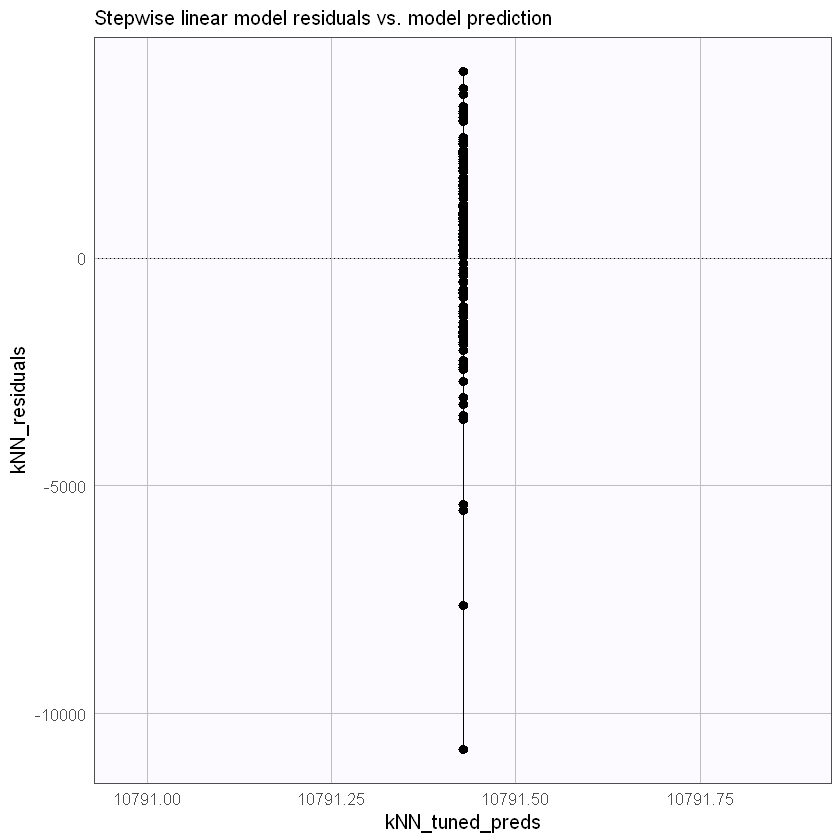

In [108]:
ggplot(test, aes(x = kNN_tuned_preds, y = kNN_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = kNN_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("Stepwise linear model residuals vs. model prediction")

In [109]:
kNN_tuned$results

k,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
5,1352.409,0.8365148,846.2401,121.13721,0.02844064,49.10423
7,1337.478,0.8395819,846.6889,110.43178,0.02435167,50.41435
9,1346.488,0.8375186,860.0555,94.83665,0.02008584,43.72562
11,1362.538,0.8336376,877.8751,87.57107,0.01868836,43.33982


### Model comparison

In [113]:
#Leaving out the negative linear regression OSR2
performance = c(mod_rf_untuned_OSR2, mod_rf_tuned_OSR2, mod_pls_tuned_OSR2, mod_rpart_tuned_OSR2, xgb_tuned_OSR2, pcr_OSR2, stepwise_OSR2, kNN_OSR2)
model = c("Untuned RF", "Tuned RF", "pls", "Rpart", "XGboost", "pcr", "stepwise", "kNN")

In [114]:
comparison <- data.frame(performance, model)
comparison

performance,model
0.8603799,Untuned RF
0.8649955,Tuned RF
0.8170892,pls
0.8582117,Rpart
0.8631993,XGboost
0.7641474,pcr
0.8736403,stepwise
0.8582302,kNN


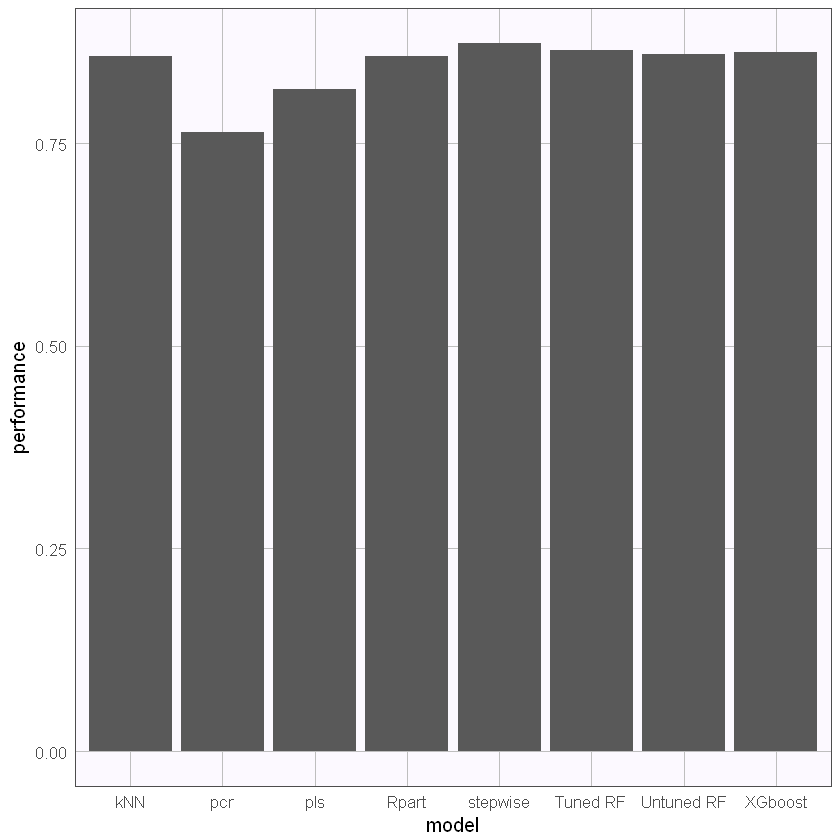

In [115]:
ggplot(comparison, aes(x=model, y=performance)) + geom_bar(stat = "identity")

In [249]:
# # options(repr.plot.width=7, repr.plot.height=7)
# check2(df,df$Day.Nber, df$cumFuture_BioCNG10daysAhead)
# min(df$cumFuture_BioCNG10daysAhead, na.rm=TRUE)
# max(df$cumFuture_BioCNG10daysAhead, na.rm=TRUE)

In [250]:
# check(df,df$AlcoWaste_Input,bin=10)

In [1]:
#CHECK THIS FOR TIME-SLICING:
# https://stackoverflow.com/questions/24758218/time-series-data-spliting-and-model-evaluation